In [22]:
import numpy as np
from IPython.display import clear_output

## Implements Sensofarreader.m
import sensofar_reader as sr
import alicona_mesh as al_mesh
from tqdm import tqdm
import Edge
import util
import pandas as pd
import openpyxl

import importlib
importlib.reload(util)

import matplotlib.pyplot as plt

from matplotlib import cm
from matlab.engine import MatlabExecutionError
import os
import CircleFitByPratt
import math

import matlab
import matlab.engine

eng = matlab.engine.start_matlab("-noFigureWindows")
#eng = matlab.engine.start_matlab()
eng.addpath(r'./Version_1_7')

#Disable beeping
eng.beep_off(nargout = 0)

##Kinda ugly workaround to "eng.addpath" outputing every file it adds.....
clear_output(wait=True)

In [13]:
importlib.reload(util)

<module 'util' from 'd:\\01_Programe\\Github\\iwf_stuff\\MATLABSKRIPT_SCHNEIDKANTENRADIEN\\util.py'>

In [14]:
# Step 1: Read data
#mesh = sr.read_dat()

path=r"D:\01_Programe\Github\iwf_stuff\MATLABSKRIPT_SCHNEIDKANTENRADIEN\Schneidkantenradius_Daten"
#path=r"."
file = "659_1_T222_L1.dat"
results_folder = file.split(".")[0]
os.makedirs(os.path.join(path, results_folder), exist_ok=True)

In [15]:

data = np.genfromtxt(os.path.join(path,file), delimiter=';')
x_values = data[:, 0]/10**3
y_values = data[:, 1]/10**3
z_values = data[:, 2]/10**3
x_dim = np.unique(x_values).shape[0]
y_dim = np.unique(y_values).shape[0]
Z = z_values.reshape(y_dim, x_dim)
X = x_values.reshape(y_dim, x_dim)
Y = y_values.reshape(y_dim, x_dim)

In [16]:
mesh = al_mesh.Mesh(X, Y, Z, np.nanmin(z_values), np.nanmax(z_values), x_dim, y_dim)

#Step 2: Filter data according to MATLAB script
## a: for every x-value: subract maximum Z value from all values: puts cutting edge onto Z=0 and everything else negative
mesh.shift_to_zero()

## b: min max
mesh.min_max_filter(-0.05, 0.05)

## d: filter to only cutting edge:
##TODO:: Currently extremely inneficient !!!!
mesh.filter_cutting_edge()

end_ind

C:\Users\kfabian\AppData\Local\Temp/ipykernel_84396/3734131331.py:8: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(mesh.X[:, :start_ind], mesh.Y[:, :start_ind], mesh.Z[:, :start_ind], color = "grey", linewidth=0, cstride = 10, rstride= 10)
C:\Users\kfabian\AppData\Local\Temp/ipykernel_84396/3734131331.py:9: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(mesh.X[:, start_ind:end_ind], mesh.Y[:, start_ind:end_ind], mesh.Z[:, start_ind:end_ind], cmap=cm.jet, linewidth=0, cstride = 10, rstride= 10)
C:\Users\kfabian\AppData\Local\Temp/ipykernel_84396/3734131331.py:10: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(mesh.X[:, end_ind:], mesh.Y[:, end_ind:], mesh.Z[:, end_ind:], color = "grey", linewidth=0, cstride = 10, rstride= 10)


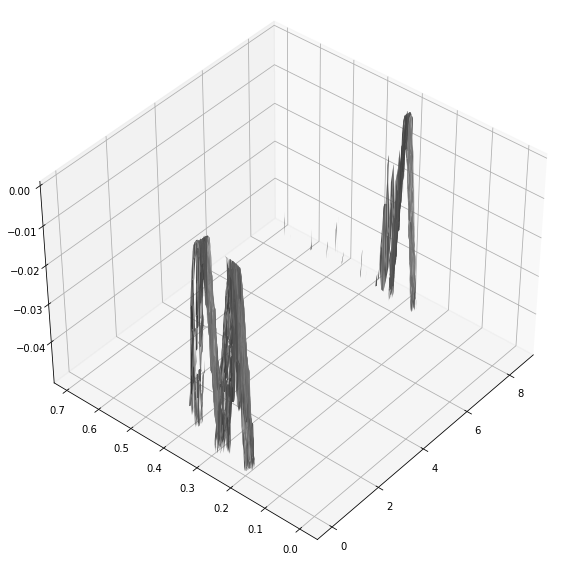

In [17]:
start_ind = 1000
end_ind = mesh.x_dim - 500 ###TODO: Set to value to exclude irrelevant slices

%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot( projection='3d')

ax.plot_surface(mesh.X[:, :start_ind], mesh.Y[:, :start_ind], mesh.Z[:, :start_ind], color = "grey", linewidth=0, cstride = 10, rstride= 10)
ax.plot_surface(mesh.X[:, start_ind:end_ind], mesh.Y[:, start_ind:end_ind], mesh.Z[:, start_ind:end_ind], cmap=cm.jet, linewidth=0, cstride = 10, rstride= 10)
ax.plot_surface(mesh.X[:, end_ind:], mesh.Y[:, end_ind:], mesh.Z[:, end_ind:], color = "grey", linewidth=0, cstride = 10, rstride= 10)
ax.pbaspect = [6.0, 0.6, 0.25]
ax.azim = -140
ax.elev = 40
plt.show()

In [18]:
def main_conti_profiles (edge: Edge, LS_Toplimit: float, x_value: float, save_location: str, matlab_engine, save_radius_plot = False) -> dict:
    
    ##Python implemntation of the MATLAB function "main_conti_profiles"
    err = 0.0
    params_in = {}
    params_in["bman"] = 0
    params_in["lowerlimit1"]=200e-6;
    params_in["upperlimit1"]=30e-6;
    params_in["lowerlimit2"]=100e-6;
    params_in["filter"]=2.0;
    params_in["polydegree"]=5.0;
    params_in["u_p"] = 3e-6;

    params_out = {}

    matlab_edge = util.matlab_edge_conversion(edge)
    for i in range(2):
        matlab_edge = matlab_engine.trim_edge(matlab_edge, float(3e-3/j), nargout=1)
        matlab_edge = matlab_engine.kantenbereich(matlab_edge, float(LS_Toplimit), nargout=1)

        matlab_edge = matlab_engine.str_line(matlab_edge, 'b', 'c', 0, 0, nargout=1)
        matlab_edge = matlab_engine.shift_any(matlab_edge, matlab_edge["y_inter"], matlab_edge["z_inter"], nargout=1)
        matlab_edge = matlab_engine.str_line(matlab_edge, 'b', 'c', 0, 0, nargout=1)
        alpha = (matlab_edge["angle_l"]+matlab_edge["angle_r"])/2.0
        matlab_edge = matlab_engine.rotate_edge(alpha, matlab_edge, 1, nargout=1)
        matlab_edge = matlab_engine.str_line(matlab_edge, 'b', 'c', 0, 0, nargout=1)

        #print(matlab_edge)

    #%DETRMINE DELTA_R and b-SECTION--------------------------------------------------------
    if max(np.asarray(matlab_edge["edge"])[0].imag) < matlab_edge["z_inter"]:


        # choose new limits for LS-straight lines (set by user)
        lowerlimit1=float(max(np.asarray(matlab_edge["edge"])[0].imag) + params_in["lowerlimit1"])
        upperlimit1=float(max(np.asarray(matlab_edge["edge"])[0].imag) + params_in["upperlimit1"])
        matlab_edge = matlab_engine.startpositions(matlab_edge, upperlimit1, lowerlimit1, nargout=1)

        #determine indexes of points lying withing the limits
        matlab_edge = matlab_engine.re_alignment(matlab_edge, nargout=1)

        #determine delta_r------------------------------------------
        matlab_edge,z_bisect,plc1,plc2 = matlab_engine.getdelta_r(matlab_edge,0, nargout=4);

        # determine b-section-----------------------------------------
        kl, kr, pg, matlab_edge = matlab_engine.getb(params_in, matlab_edge, z_bisect, 0, nargout=4);

        # second time (LS lines with new regions)______________________________________
        # %choose new limits for LS-straight lines (also set by user)
        lowerlimit2 = max(np.asarray(matlab_edge["edge"])[0].imag) + params_in ["lowerlimit2"]

        if kl>1:
            upperlimit2=min(np.asarray(matlab_edge["edge"])[0][int(kl)-2].imag, np.asarray(matlab_edge["edge"])[0][int(kr)].imag)
        else:
            upperlimit2 = 0.0;

        matlab_edge = matlab_engine.startpositions(matlab_edge, float(upperlimit2), float(lowerlimit2), nargout=1)
        matlab_edge = matlab_engine.re_alignment(matlab_edge, nargout=1)

        # new delta_r------------------------------------------------------
        matlab_edge,z_bisect,plc1,plc2 = matlab_engine.getdelta_r(matlab_edge, 0, nargout=4);

        # new b-section----------------------------------------------------
        kl,kr,pg,matlab_edge = matlab_engine.getb(params_in, matlab_edge, z_bisect, 0, nargout=4);
    else:
        err = 1.0
    
    ## CALCULATION OF S, SKEWNESS (Schiefe/Schräge), kurtosis (Wölbung)

    # calculate Skewness and kurtosis
    p_distr, matlab_edge = matlab_engine.convert_to_probability(matlab_edge, nargout = 2) # converts geometric "distribution" (point coordinate information) into probability distribution

    #calculate S
    matlab_edge = matlab_engine.calc_S(matlab_edge, kl, kr, plc1, plc2, z_bisect, nargout = 1);

    if err==0: # (there are points in [-b,+b])

        #determine dl_schn and dr_schn-------------------------------------

        # 1.dl and dr are determined at the outer most points of the b-section
        sl = matlab_edge["bl"];
        sr = matlab_edge["br"];

        dl_b,dr_b = matlab_engine.getdldr(sl, sr, z_bisect, kl, kr, matlab_edge, nargout = 2);



        # 2.dl and dr are determined at points of intersection between horizontal (green) line and clearance and
        # rake straight lines
        #print(matlab_edge["strline_left"][0][1])
        sl=(z_bisect-matlab_edge["strline_left"][0][1])/matlab_edge["strline_left"][0][0];
        sr=(z_bisect-matlab_edge["strline_right"][0][1])/matlab_edge["strline_right"][0][0];
        
        dl_schn, dr_schn = matlab_engine.getdldr(sl, sr, z_bisect, kl, kr, matlab_edge, nargout = 2);
        

        # Fit (black) circle into edge Geometry (into green region
        # [-b;+b])------------------------------------------------------------
        #print(np.real(matlab_edge["edge"][int(kl):int(kr)]))
        #print()

        ## Ugly work around to pass numpy array into matlab
        transpose_real = matlab.double(np.transpose(np.real(matlab_edge["edge"]))[int(kl)-1:int(kr)-1].tolist())
        transpose_imag = matlab.double(np.transpose(np.imag(matlab_edge["edge"]))[int(kl)-1:int(kr)-1].tolist())
        xc, yc, R, a, R_squared = matlab_engine.circfit(transpose_real, transpose_imag, nargout = 5)
        th = np.arange(0, 2*np.pi+0.1, 0.1, dtype=float)

        #xn=xc+R*math.sin(th)
        xn = [xc + R*math.sin(th_) for th_ in th]
        #yn=yc+R*math.cos(th);
        yn = [yc + R*math.cos(th_) for th_ in th]

        real = np.real(matlab_edge["edge"][0])*1e3  ## Get cutting edge and convert to mm
        imaginary = np.imag(matlab_edge["edge"][0])*1e3  ## Get cutting edge and convert to mm

        if R_squared.real<=0.90 or R_squared.imag != 0 : # %if circle doesnt fit geometry sufficiently assume that there is a chamfer
            params_out["fase_angle"], params_out["fase_lmatlab_engineth"], params_out["r_squared_f"] = matlab_engine.fasecalc(kl,kr,pg,matlab_edge, nargout = 3);
        else:
            params_out["fase_angle"]=0;
            params_out["fase_lmatlab_engineth"]=0;
            params_out["r_squared_f"]=0;

        # ideal fitted circle (red) with radius r_n between LS-lines for face
        # and flank


        # r_n=kante.delta_r./((1/sin(pi/180*kante.openingangle/2))-1);%radius of ideal circle fitted between face and flank
        r_n = matlab_edge["delta_r"] / ((1/math.sin(math.pi/180*matlab_edge["openingangle"]/2))-1)
        xic=0;
        yic=z_bisect-r_n;
        #xi=xic+r_n*sin(th);
        xi = [xic + r_n*math.sin(th_) for th_ in th]
        # yi=yic+r_n*cos(th);
        yi = [yic + r_n*math.cos(th_) for th_ in th]

        # determine angular range of points b of fitted circle
        #  line1=polyfit([xc real(kante.edge(kl))],[yc imag(kante.edge(kl))],1);
        line1 = np.polyfit([xc, matlab_edge["edge"][0][int(kl)-1].real], [yc, matlab_edge["edge"][0][int(kl)-1].imag], 1)
        x1 = [xc, matlab_edge["edge"][0][int(kl)-1].real]
        y1=[line1[0]*x + line1[1] for x in x1]

        # line2=polyfit([xc real(kante.edge(kr))],[yc imag(kante.edge(kr))],1);
        line2 = np.polyfit([xc, matlab_edge["edge"][0][int(kr)-1].real], [yc, matlab_edge["edge"][0][int(kr)-1].imag], 1)
        x2=[xc, matlab_edge["edge"][0][int(kr)-1].real];
        #y2=line2(1).*x2+line2(2);
        y2=[line2[0]*x + line2[1] for x in x1]

        arr = math.atan(line1[1])-math.atan(line2[0]);
        arr = 180-abs(arr/math.pi*180) #%angular range in degrees
        if save_radius_plot:
            util.save_cutting_edge_radius_plot (real, imaginary, real[int(kl)-1:int(kr)-1], imaginary[int(kl)-1:int(kr)-1],(xc*1e3, yc*1e3), R*1e3, (xic*1e3, yic*1e3), r_n*1e3, save_location)

    params_out["r_n"]=r_n   # radius of ideal circle
    params_out["r"]=R       # radius of fitted circle
    params_out["xc"]=xc     # position of circle centre point
    params_out["yc"]=yc     # position of circle centre point
    params_out["b"]=pg      # number of points in b-region
    params_out["kante"]=matlab_edge;
    params_out["zmax"]=max([x.imag for x in matlab_edge["edge"][0]]);
    params_out["arr"]=arr   # angular range of points in b
    params_out["dl_schn"]=dl_schn;
    params_out["dr_schn"]=dr_schn;
    params_out["dl_b"]=dl_b;
    params_out["dr_b"]=dr_b;
    params_out["r_squared"]=R_squared;
    return params_out     



In [19]:
##Step 3: for every slice along x-axis, derive cutting edge metrics
max_scan_depth = np.zeros(end_ind-start_ind)
number_of_usable_values_on_edge = np.zeros(end_ind-start_ind)
radius = np.zeros(end_ind-start_ind)

results = []
Prattradius = []

## Sample stride: controls how often metrics are derived: every sample_stride-th cross section is looked at
sample_stride = 1

fail_count = 0

for i in tqdm(range(start_ind, end_ind, sample_stride)):
#for i in tqdm(range(start_ind, start_ind+100, sample_stride)):
    y_values = mesh.Y[:, i]
    z_values = mesh.Z_original[:, i]
    x_value = mesh.X[0, i]

    number_of_nans = np.count_nonzero(~np.isnan(z_values))

    if number_of_nans > 0:

        Idx_start, Idx_end = util.acceptable_range(z_values)
        #Idx_end = Idx_start + 143
        number_of_usable_values_on_edge[i-start_ind] = Idx_end - Idx_start + 1

        if  Idx_end - Idx_start == 0:
            fail_count += 1
            continue

        radius[i-start_ind] = np.nan


        edge = util.get_ridge_info(y_values[Idx_start: Idx_end]*1e-3, z_values[Idx_start: Idx_end]*1e-3)
        highest_lowest_point = max(z_values[Idx_start], z_values[Idx_end])
        max_scan_depth[i-start_ind] = -highest_lowest_point

        LS_Toplimit = min(max_scan_depth[i-start_ind]*1e-3/2.0, 30e-6)

        IdxMaxZ=np.argmax(z_values[Idx_start:Idx_end])
        Kantenwerte = 20
        XY=[]
        for j in range(Kantenwerte):
            XY.append([y_values[IdxMaxZ-int(Kantenwerte/2)+j], z_values[IdxMaxZ-int(Kantenwerte/2)+j]])
        MP, RadiusPratt = CircleFitByPratt.CircleFitByPratt(XY)

        Prattradius.append(RadiusPratt)


        try:
            file_name = os.path.join(path, results_folder, f"iteration_{i}_x_{x_value}_radius.png")

            ## i%100 ensures only every 100th slice is saved, saving is slow
            res = main_conti_profiles(edge, LS_Toplimit,  round(x_value, 6), save_location = file_name, matlab_engine=eng, save_radius_plot = i%100 == 0)
            res["x_value"] = round(x_value, 6)
            results.append(res)
            #print(res)

        except MatlabExecutionError:
            fail_count += 1

##Dump results to a csv, use "relevant_cols" to choose which values are dumped
file_name = os.path.join(path, results_folder, f"results.csv")
util.save_results_to_csv(results, file_name, relevant_cols = ['x_value', 'r_squared_f', 'r_n', 'r', 'skewness'])
print("Done")
print(f"In total {fail_count} out of {end_ind-start_ind} failed")




100%|██████████| 10853/10853 [14:12<00:00, 12.74it/s]

Done
In total 4435 out of 10853 failed


In [20]:
radius = list(map(lambda x: x["r_n"]*1e6, results))
radius1 = list(map(lambda x: x["r"]*1e6, results))
radius2 = list(map(lambda x: x["r_squared"]*1e6, results))
x_positions = list(map(lambda x: x["x_value"], results))
kanteS = list(map(lambda x: x["kante"]["S"], results))
kanteSNew = list(map(lambda x: x["kante"]["Snew"], results))

avgradius= sum(radius)/len(radius) 
avgradius1=sum(radius1)/len(radius1) 
avgradius2=sum(radius2)/len(radius2)
avgkanteS = sum(kanteSNew)/len(kanteS)
avgkanteSNew = sum(kanteSNew)/len(kanteSNew)

Mean:  8.713006 11.85602865
SD:  4.39208821 4.97516096
Max:  27.25589035 117.41737406
Min:  0.84252691 0.44177671
CuttingEdgeRadiusEvaluated 659_1_T222_L1 saved as txt file!
Results and radii 659_1_T222_L1 saved as txt file!
Results and radii 659_1_T222_L1 saved as python array!


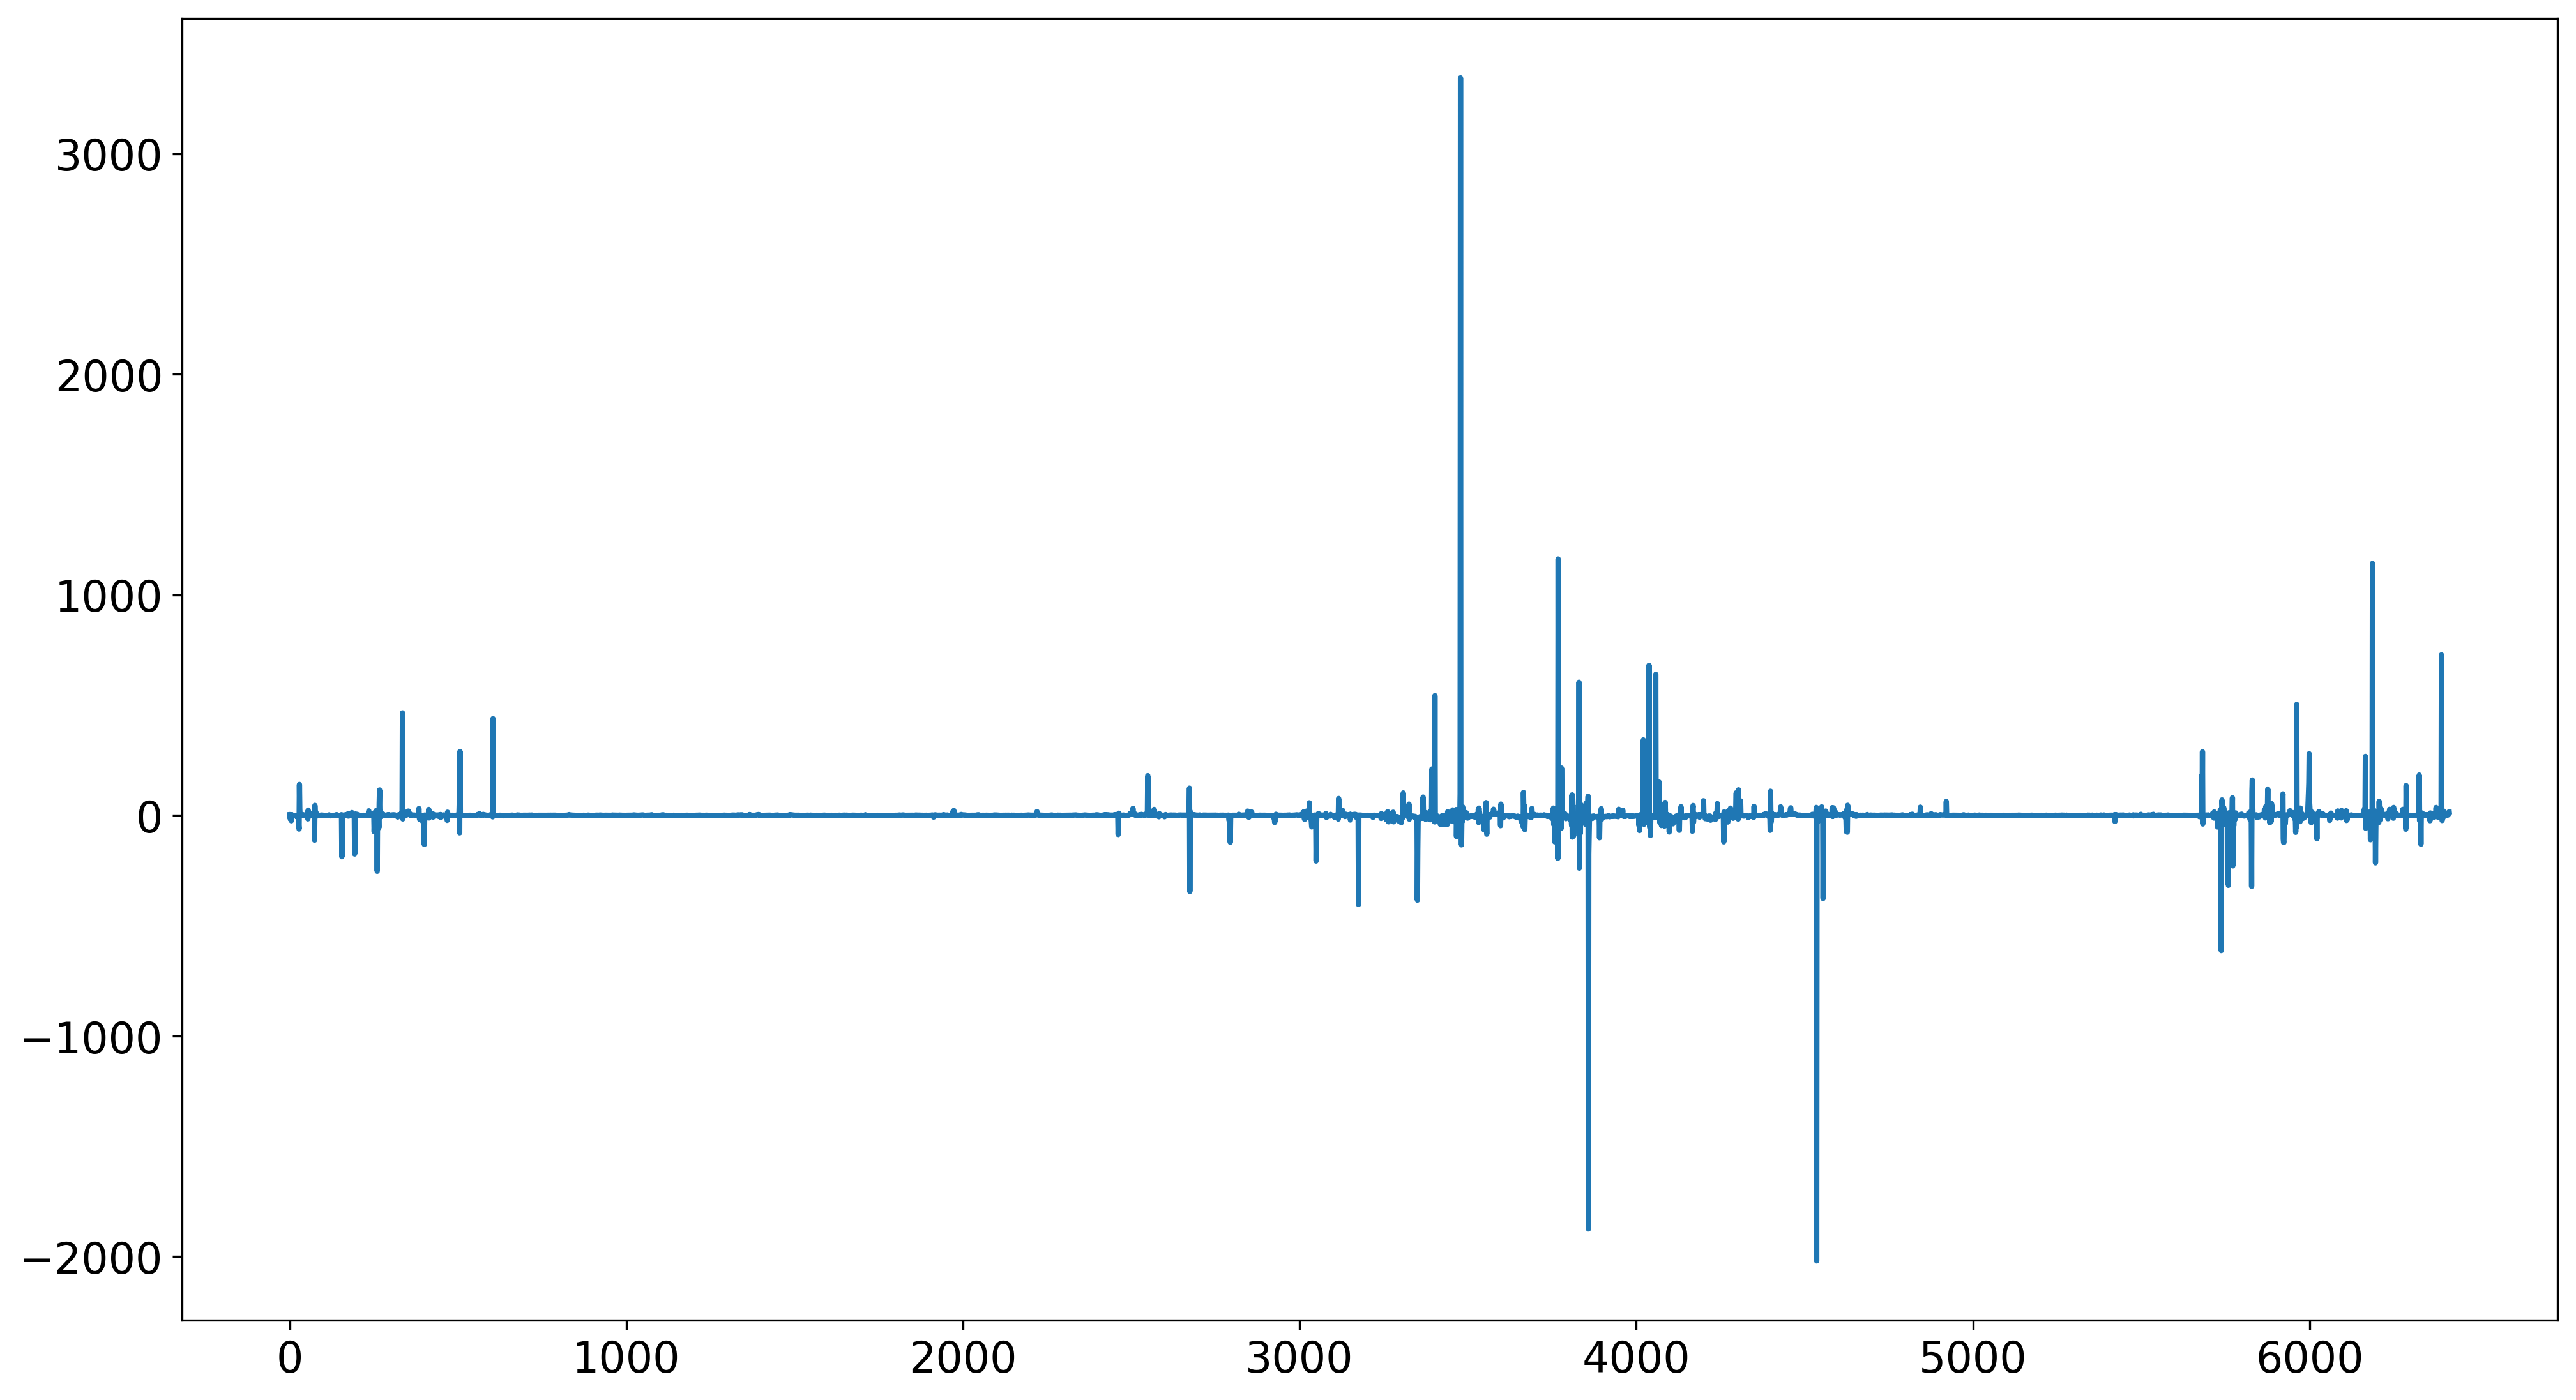

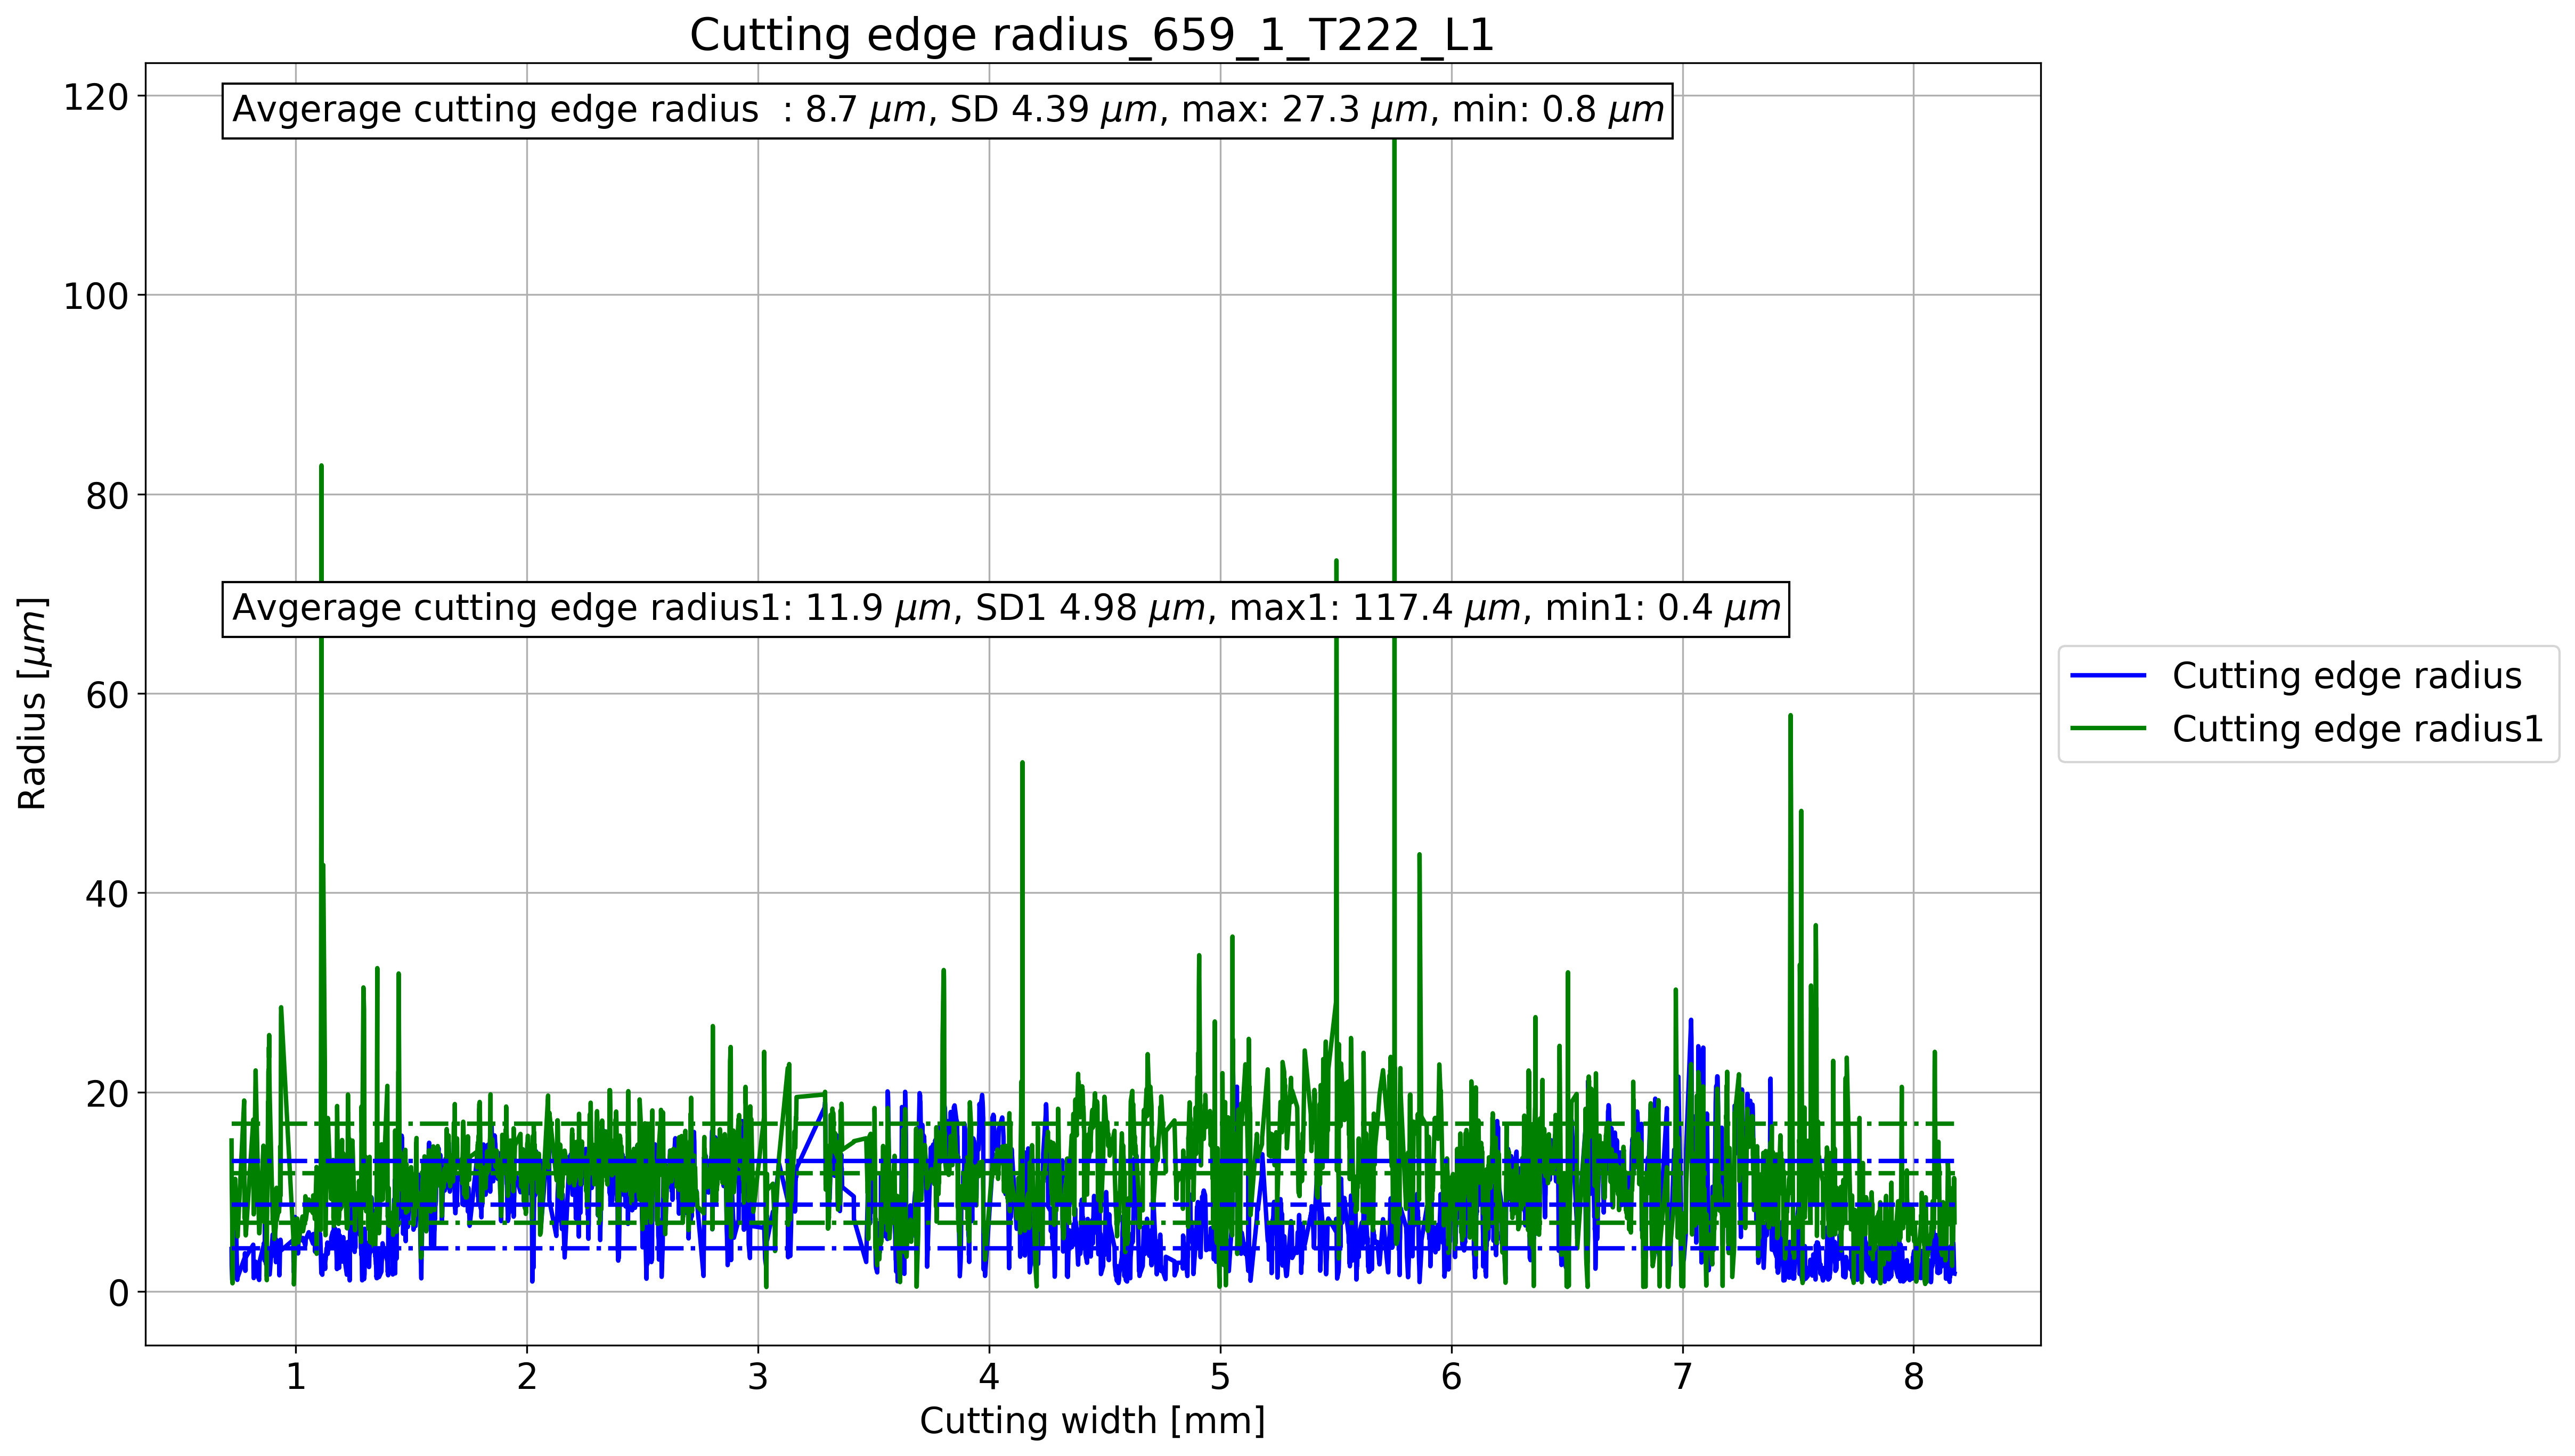

In [21]:
# User input

## Define Range in mm:
start_x = 0.0
end_x = 10.0

##Find indices representing these values
X_Min = np.argmax(np.asarray(x_positions) > max(x_positions[0], start_x))
X_Max = np.argmin(np.asarray(x_positions) < min(x_positions[-1], end_x))

EvaluationLength = x_positions[X_Max] - x_positions[X_Min] # Right borderLeft border [mm]

# Calculations
MeanRadius = np.round(np.mean(radius[X_Min:X_Max]),8)
SD_Radius = np.round(np.std(radius[X_Min:X_Max]),8)
MaxRadius = np.round(np.max(radius[X_Min:X_Max]),8)
MinRadius = np.round(np.min(radius[X_Min:X_Max]),8)

MeanRadius1 = np.round(np.mean(radius1[X_Min:X_Max]),8)
SD_Radius1 = np.round(np.std(radius1[X_Min:X_Max]),8)
MaxRadius1 = np.round(np.max(radius1[X_Min:X_Max]),8)
MinRadius1 = np.round(np.min(radius1[X_Min:X_Max]),8)

print("Mean: ", MeanRadius, MeanRadius1)
print("SD: ", SD_Radius, SD_Radius1)
print("Max: ", MaxRadius, MaxRadius1)
print("Min: ", MinRadius, MinRadius1)

# Directory
directory_fig = os.path.join(path, results_folder, 'Figures')
directory_eval = os.path.join(path, results_folder, 'Evaluation')
if not os.path.exists(directory_fig):
    os.makedirs(directory_fig)
if not os.path.exists(directory_eval):
    os.makedirs(directory_eval)

fileTitle = file[:-4]

# Save data to txt file and pyhon array
Head1 = str('File name, X_Min [mm], X_Max [mm], EvaluationLength [mm], MeanRadius [mu m], SD_Radius [mu m], MaxRadius [mu m], MinRadius [mu m]')
Head2 = str('Radii [mu m], Radii1 [mu m]')

DataToSave0 = np.concatenate(([fileTitle], [X_Min],[X_Max],[EvaluationLength],[MeanRadius], [SD_Radius], [MaxRadius], [MinRadius]))
DataToSave1 = np.concatenate(([fileTitle], [X_Min],[X_Max],[EvaluationLength],[MeanRadius1], [SD_Radius1], [MaxRadius1], [MinRadius1]))
DataToSave1 = np.vstack(([DataToSave0], [DataToSave1]))
DataToSave2 = np.column_stack((np.asarray(radius),np.asarray(radius1)))

Datafile_path1 = os.path.join(directory_eval, "CuttingEdgeRadiusEvaluated_" + fileTitle)
Datafile_path2 = os.path.join(directory_eval, "CuttingEdgeRadii_" + fileTitle)

np.savetxt(Datafile_path1+".txt", DataToSave1, fmt='%s', delimiter=' ', header=Head1)
print("CuttingEdgeRadiusEvaluated " + fileTitle + " saved as txt file!")
np.savetxt(Datafile_path2+".txt", DataToSave2, fmt='%s', delimiter=' ', header=Head2)
print("Results and radii " + fileTitle + " saved as txt file!")
# Save data as python array
np.save(Datafile_path1, DataToSave1)
np.save(Datafile_path2, DataToSave2)
print("Results and radii " + fileTitle + " saved as python array!")

# Plot settings
# Font size plots
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 20})
# Line width
plt.rcParams["lines.linewidth"] = 2

plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams['figure.dpi'] = 300

plt.plot(kanteS[X_Min:X_Max])

fig, bx = plt.subplots(constrained_layout=True)

bx.plot(x_positions[X_Min:X_Max], radius[X_Min:X_Max], zorder=2, label=r'Cutting edge radius', color='b')
bx.plot(x_positions[X_Min:X_Max], radius1[X_Min:X_Max], zorder=2, label=r'Cutting edge radius1',color='g')

bx.hlines(y = MeanRadius, xmin=x_positions[X_Min], xmax=x_positions[X_Max], color = 'b', linestyle="--", zorder=8)
bx.hlines(y = MeanRadius+SD_Radius, xmin=x_positions[X_Min], xmax=x_positions[X_Max], color = 'b', linestyle="-.", zorder=8)
bx.hlines(y = MeanRadius-SD_Radius, xmin=x_positions[X_Min], xmax=x_positions[X_Max], color = 'b', linestyle="-.", zorder=8)

bx.hlines(y=MeanRadius1, xmin=x_positions[X_Min], xmax=x_positions[X_Max], color = 'g', linestyle="--", zorder=8)
bx.hlines(y = MeanRadius1+SD_Radius1, xmin=x_positions[X_Min], xmax=x_positions[X_Max], color = 'g', linestyle="-.", zorder=8)
bx.hlines(y = MeanRadius1-SD_Radius1, xmin=x_positions[X_Min], xmax=x_positions[X_Max], color = 'g', linestyle="-.", zorder=8)

bx.ticklabel_format(useOffset=False, style='plain')
bx.ticklabel_format(useOffset=False)

bx.set_xlabel(r'Cutting width [mm]')
bx.set_ylabel(r'Radius [$\mu m$]')
bx.set_title(r'Cutting edge radius_' + fileTitle)
bx.legend(loc='center left', bbox_to_anchor=(1, 0.5))

text_MeanRadius = bx.text(0, 0, "")
text_MeanRadius1 = bx.text(0, 0, "")

t_MeanRadius = "Avgerage cutting edge radius  : {:.1f} $\mu m$, SD {:.2f} $\mu m$, max: {:.1f} $\mu m$, min: {:.1f} $\mu m$".format(MeanRadius, SD_Radius, MaxRadius, MinRadius)
t_MeanRadius1 = "Avgerage cutting edge radius1: {:.1f} $\mu m$, SD1 {:.2f} $\mu m$, max1: {:.1f} $\mu m$, min1: {:.1f} $\mu m$".format(MeanRadius1, SD_Radius1, MaxRadius1, MinRadius1)

text_MeanRadius.set_text(t_MeanRadius)
text_MeanRadius.set_position((x_positions[X_Min], MaxRadius1 + 0 * SD_Radius))
text_MeanRadius.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))
text_MeanRadius.set_zorder(10)

text_MeanRadius1.set_text(t_MeanRadius1)
text_MeanRadius1.set_position((x_positions[X_Min], MaxRadius1 - 50))
text_MeanRadius1.set_bbox(dict(facecolor='white', alpha=1, edgecolor='black'))
text_MeanRadius1.set_zorder(10)
plt.grid()

## Hides ouliers:
# plt.ylim(0, 100)

plt.savefig(os.path.join(directory_fig, "CuttingEdgeRadius_" + fileTitle + ".png"), facecolor='white', transparent=False, dpi=300, bbox_inches='tight')

plt.show()
plt.close()

In [288]:
##TODO: extrace any metrics needed from results array

In [497]:
## Don't forget to stop MATLAB engine
eng.quit()